**PIPELINE**:

**Train**: 

1. $r_t = r_0 + c_1 t$

2. $c_1(\phi, \mu) \approx p_0(\mu) + p_1(\mu)\phi  + p_2(\mu) \phi^2 + \cdots$

3. New mapping: either $g: \mu \rightarrow c_1$ or $g: \mu \rightarrow (p_0, p_1, p_2, \cdots)$

**Test**:
1. Sample $\mu^{\ast}$

2. Push through $g$, get $c_1$

3. $r_t^{\ast} = r_0^{\ast} + c_1^{\ast} t$

4. Predictive uncertainty? 


5. Inference on $\mu$?? $\color{red}{\text{(details to follow)}}$

**Transfer**

(need some more reliable edge data for this, but using some limited samples)

1. Specify $r_0$

2. Specify $\mu$

3. Assume covariate shift i.e. shift in $\phi$ and $\mu$ (tricky for $\phi$? $\phi$ actually depends on $\mu$? or at least on orientation!) - can we make this conditional on $\phi$ and reframe?

4. Reweigh samples

5. Generate new predictions

Same concept as previous notebook, but trying to learn an approximate instead of exact GP to avoid memory intensive calculation.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from sklearn.preprocessing import StandardScaler
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

from matplotlib import pyplot as plt

In [5]:
import re
import os

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
%matplotlib inline

In [8]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [9]:
import edge_utils as edut

Load data

In [10]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [11]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [12]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [13]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

Least Squares Fit (don't need non-linear because of independence of $k$ and $\tau$.

In [14]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [15]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [16]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [17]:
rd_2161 = getRValuesAllSims(ed_2161)

In [18]:
data_dim = rd_2161.shape[1]
data_dim

160

In [19]:
# param_dim = cme_params_to_augment.shape[1]
# param_dim

In [20]:
# augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
# augmented_r[:, :(data_dim), :] = rd_2161
# for iii in range(rd_2161.shape[2]):
#     augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [21]:
def lin_velocity_func(x, t, y):
    return x[0] * t - y

In [22]:
def gen_velocities(t, c1):
    return c1 * t

In [23]:
from scipy.optimize import least_squares

In [24]:
def fit_velocity(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160), 
                lsq_loss="soft_l1",
                fscale=0.1,
                x0 = [0.00517464 * 400]):
    """
    for a chosen sim ID, fit least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 1
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 1))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(lin_velocity_func,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                bounds=(0, np.inf),
                                verbose=0)
        
        
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_velocities(t_train, *res_lsq.x) + r0[pa_idx]
    
    return lsq_params, r_pred, r_vals_valid

In [25]:
def fit_velocity_v2(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160), 
                ):
    """
    for a chosen sim ID, fit least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 1
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 1))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        
        res_lsq = np.linalg.lstsq(np.expand_dims(t_train, 1), r_train[:, pa_idx])[0]
        
        #         res_lsq = least_squares(lin_velocity_func,
        #                                 x0,
        #                                 loss=lsq_loss,
        #                                 args=(t_train, r_train[:, pa_idx]),
        #                                 bounds=(0, np.inf),
        #                                 verbose=0)


        lsq_params[pa_idx, :] = res_lsq
        #         r_pred[1:, pa_idx] = gen_velocities(t_train, *res_lsq.x) + r0[pa_idx]
    
        return lsq_params, r_pred, r_vals_valid

In [26]:
# params_s0, r_pred_s0, r_vals_s0 = fit_velocity(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

In [27]:
# params_s0

In [28]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])
orig_sd_idx.shape

(262,)

In [29]:
# c1_params_v2 = np.zeros((160, 1, len(sd_modified)))
# for i in range(len(sd_modified)):
#     params_sheeley, r_pred_sheeley, r_vals_sheeley = fit_velocity_v2(ed_2161, 
#                                                                   sd_2161, 
#                                                                   simIdx=orig_sd_idx[i], 
#                                                                   )
    
#     c1_params_v2[:, :, i] = params_sheeley
# # #     edut.plotTrainPredData1Model(r_vals_sheeley, r_pred_sheeley, ed_2161, sd_modified, simIdx=i, 
# # #                                   savefig=True,
# # #                                   savedir="./linear_velocity_fit_all_sims"
# # #                                  )

In [30]:
# np.save("c1_least_squares_correct_linfit.npy", c1_params_v2)

In [31]:
c1_params = np.load("c1_least_squares_correct.npy") # fitted with non-linear alg
# c1_params = np.load("c1_least_squares_correct_linfit.npy") # fitted with linear lstsq, which is probably better

In [32]:
c1_params.shape

(160, 1, 262)

In [33]:
def getDataForLinearFit(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160)):
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    r_vals_valid = r_vals[valid_time_idx, :]

    r0 = r_vals_valid[0, :]


    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0

    return r_train, t_train

In [34]:
r_train203, t_train203 = getDataForLinearFit(ed_2161, sd_2161, simIdx=159)

In [35]:
# for sidx, sid in enumerate(sd_modified):
#     plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, sidx], label="")
#     plt.xlabel("phi")
#     plt.xlim((-31, 82))
#     plt.title("Sim {} c1".format(sid))
#     plt.savefig(os.path.join("c1_figs", "Sim_{:03d}_c1.png".format(sid)))
#     plt.close()

Text(0.5, 1.0, 'c1 selected')

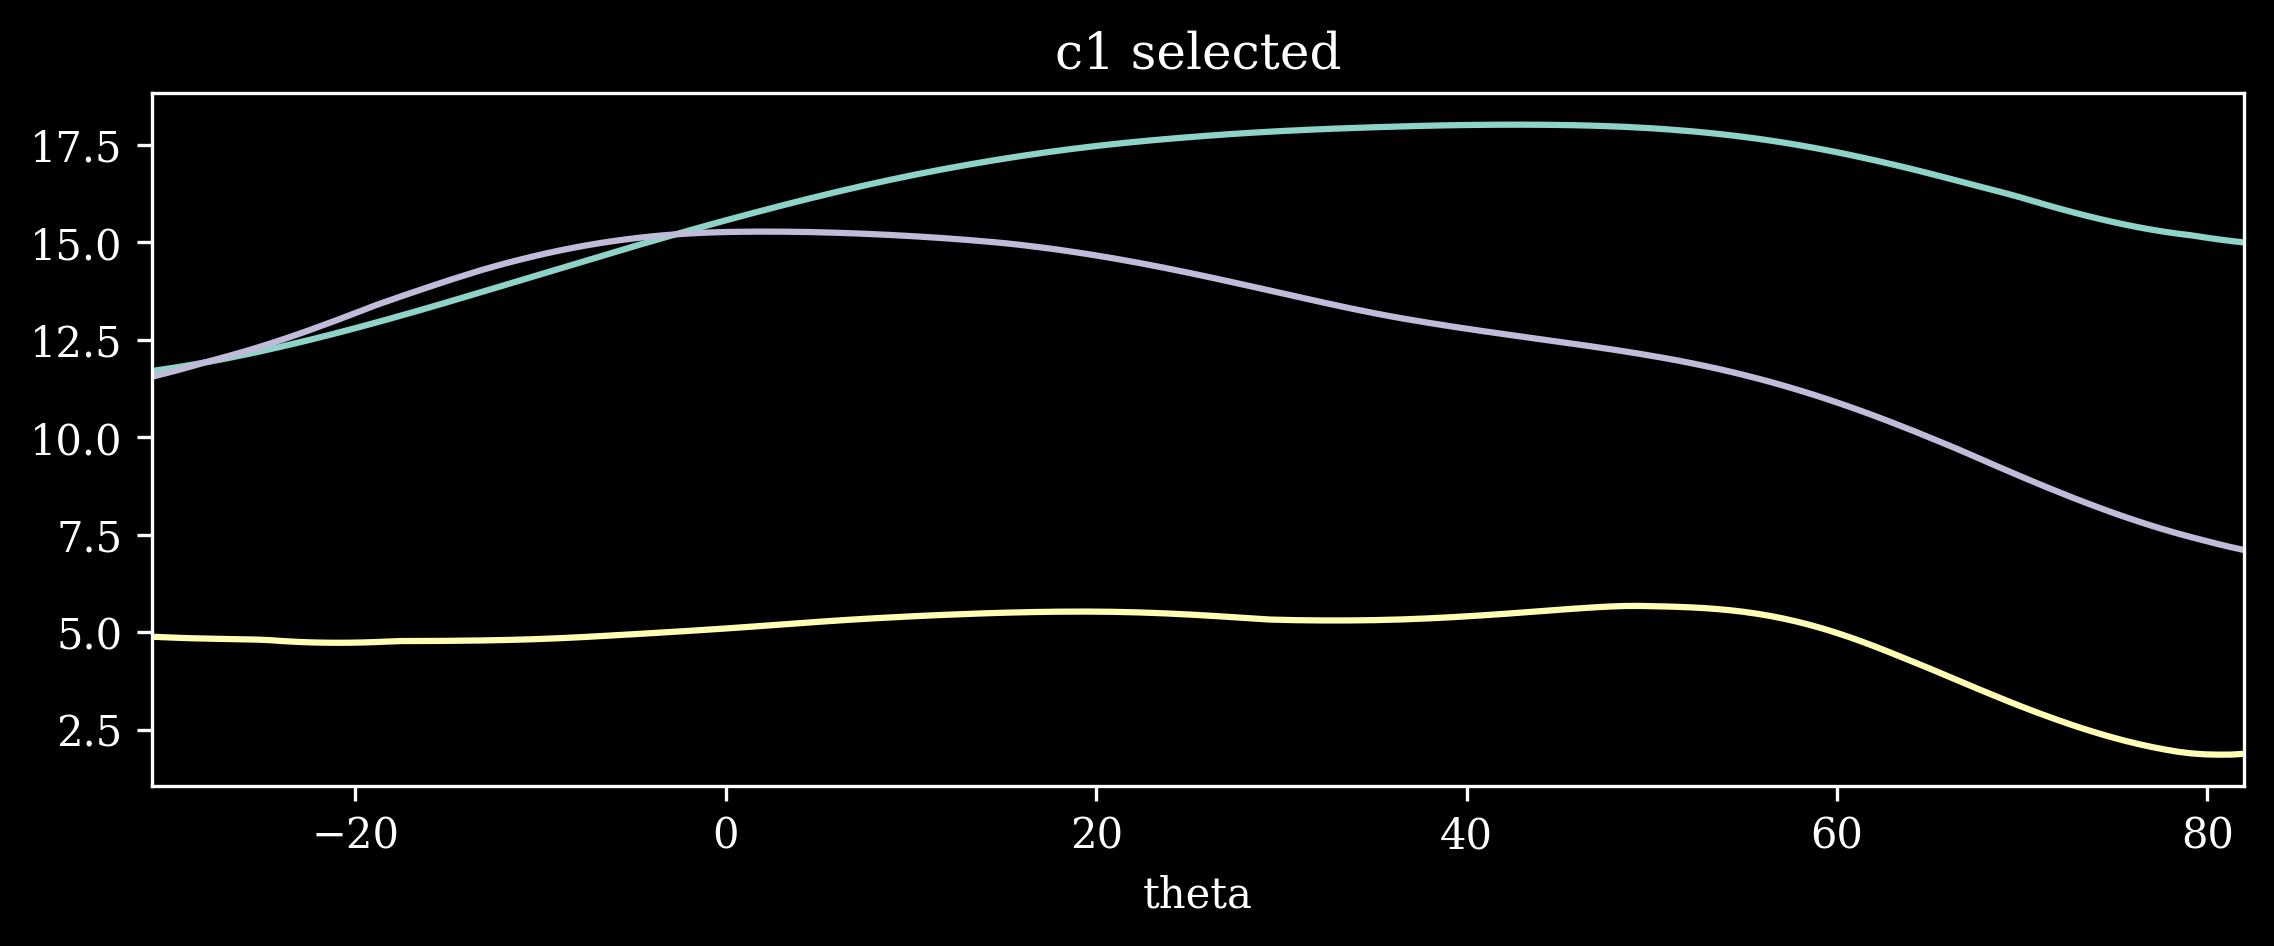

In [36]:
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 0], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 1], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 20], label="")
plt.xlabel("theta")
plt.xlim((-31, 82))
plt.title("c1 selected")

#### Load CME Parameters

In [37]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [38]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")

In [39]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [40]:
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

In [41]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()


cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [42]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [43]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [44]:
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [45]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

**Split into train and test for GPs**

In [46]:
from numpy.random import Generator, PCG64
rng = np.random.default_rng(2023)

nTrain = int(np.floor(0.6 * len(sd_modified)))
nCalib = int(np.floor(0.2 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

nTrain, nTest, nCalib

(157, 53, 52)

In [47]:
len(sd_modified)

262

In [48]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])

In [49]:
sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))
sd_test_calib = np.setdiff1d(sd_modified, sd_train)
sd_calib = np.sort(rng.choice(sd_test_calib, nCalib, replace=False))
sd_test = np.setdiff1d(sd_test_calib, sd_calib)

sd_test, sd_calib

(array([ 36,  41,  43,  48,  50,  70,  79,  81,  85,  89,  92,  94, 101,
        114, 118, 119, 135, 140, 141, 151, 158, 164, 168, 169, 172, 174,
        178, 180, 188, 200, 204, 206, 211, 213, 214, 224, 230, 240, 243,
        246, 251, 254, 259, 261, 263, 267, 278, 288, 292, 307, 311, 320,
        328]),
 array([ 31,  35,  44,  46,  56,  61,  76,  95,  98, 105, 122, 123, 127,
        129, 143, 144, 146, 147, 153, 159, 175, 190, 194, 197, 205, 215,
        225, 231, 236, 239, 248, 249, 252, 255, 257, 258, 269, 274, 279,
        281, 284, 294, 298, 299, 302, 305, 306, 314, 316, 318, 319, 321]))

In [50]:
train_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
test_sd_idx  = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [51]:
train_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [52]:
test_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_test])

#### Process data

In [53]:
theta_grid_scaled = (theta_grid[0::2] - theta_grid[0])/(theta_grid[-1] - theta_grid[0])

In [54]:
theta_repeat = np.tile(theta_grid_scaled, len(train_sd_idx))

Check indexing

In [55]:
train_x_raw = cme_params_to_augment[train_sd_idx, :]
test_x_raw = cme_params_to_augment[test_sd_idx, :]

In [56]:
# train_x_raw.shape

In [57]:
# train_x_repeat = np.repeat(train_x_raw, len(theta_grid_scaled), axis=0)
# train_x_repeat.shape

In [58]:
# test_x_repeat = np.repeat(test_x_raw, len(theta_grid_scaled), axis=0)
# test_x_repeat.shape

In [59]:
# train_x_final = np.c_[theta_repeat, train_x_repeat]

In [60]:
# train_x_final.shape

In [61]:
# train_x_torch = torch.tensor(np.float32(train_x_final)).to(device)

In [62]:
# test_x_final = np.c_[np.tile(theta_grid_scaled, len(test_sd_idx)), test_x_repeat]

In [63]:
# test_x_final.shape

In [64]:
# test_x_torch = torch.tensor(np.float32(test_x_final)).to(device)

In [65]:
# c1_params_2d = np.squeeze(c1_params)

In [66]:
# train_y = c1_params_2d[0::2, train_sd_idx_modified].T.flatten()
# train_y.shape

In [67]:
# test_y = c1_params_2d[0::2, test_sd_idx_modified].T.flatten()
# test_y.shape

In [68]:
# train_y_torch = torch.tensor(np.float32(train_y)).to(device)

In [69]:
# train_y_torch.shape

In [70]:
# test_y_torch = torch.tensor(np.float32(test_y)).to(device)

### Fit Polynomials

Learn polynomial mapping between $c_1$ and flux rope parameters, then construct a GP using a small number of $c_1$ values and parameters. Alternately, learn the GP or a regular interpolator between the coefficients of the fitted polynomials and the flux rope parameters (eliminate dependence on position angle as an additional parameter)

The previous data processing applies to GP. Here we (probably) don't need to `tile` for position angle! - we need to see what sort of assumptions we make about the coefficients though.

**Note**: Replacing vanilla polynomial fitting with Hermite, Chebyshev, etc.

In [71]:
from numpy.polynomial.hermite import hermfit, hermval
from numpy.polynomial.legendre import legfit, legval
from numpy.polynomial.laguerre import lagfit, lagval

In [72]:
# train_x_final, test_x_final
# train_y, test_y

In [73]:
c1_params.shape

(160, 1, 262)

In [74]:
c1_params_final = np.squeeze(c1_params)

In [75]:
c1_params_train = c1_params_final[:, train_sd_idx_modified].T
c1_params_test  = c1_params_final[:, test_sd_idx_modified].T

c1_params_train.shape, c1_params_test.shape

((157, 160), (53, 160))

In [76]:
train_x_raw.shape

(157, 9)

In [77]:
test_x_raw.shape

(53, 9)

In [78]:
fit_deg = 6

In [79]:
def getPolyCoeffs(train_data, deg_to_fit, family=None):
    polynomial_coeffs = np.zeros((deg_to_fit + 1, train_data.shape[0]))
    if family is None:
        for i in range(train_data.shape[0]):
            polynomial_coeffs[:, i] = np.polyfit(theta_grid, train_data[i, :], deg=deg_to_fit)
    elif family=="hermite":
        for i in range(train_data.shape[0]):
            polynomial_coeffs[:, i] = hermfit(theta_grid, train_data[i, :], deg=deg_to_fit)
    elif family=="legendre":
        for i in range(train_data.shape[0]):
            polynomial_coeffs[:, i] = legfit(theta_grid, train_data[i, :], deg=deg_to_fit)
    elif family=="laguerre":
        for i in range(train_data.shape[0]):
            polynomial_coeffs[:, i] = lagfit(theta_grid, train_data[i, :], deg=deg_to_fit)
    
    return polynomial_coeffs

In [80]:
polynomial_coeffs_reg = getPolyCoeffs(c1_params_train, 6, family=None)

# these are ordered from low to high
polynomial_coeffs_her = getPolyCoeffs(c1_params_train, 6, family="hermite")
polynomial_coeffs_leg = getPolyCoeffs(c1_params_train, 6, family="legendre")
polynomial_coeffs_lag = getPolyCoeffs(c1_params_train, 6, family="laguerre")

In [81]:
polynomial_coeffs_reg_test = getPolyCoeffs(c1_params_test, 6, family=None)
# these are ordered from low to high
polynomial_coeffs_her_test = getPolyCoeffs(c1_params_test, 6, family="hermite")
polynomial_coeffs_leg_test = getPolyCoeffs(c1_params_test, 6, family="legendre")
polynomial_coeffs_lag_test = getPolyCoeffs(c1_params_test, 6, family="laguerre")

In [82]:
polynomial_coeffs_her.shape, polynomial_coeffs_her_test.shape

((7, 157), (7, 53))

In [83]:
def getPredPolyFit(poly_coeffs, x):
    poly_sum = 0
    deg = len(poly_coeffs) - 1
    for i in range(len(poly_coeffs)):
        poly_sum = poly_sum + poly_coeffs[i] * (x**(deg - i))
        
    return poly_sum

In [84]:
def valPolyCoeffs(new_data, poly_coeffs, family=None):
    if family is None:
        poly_sum = getPredPolyFit(poly_coeffs, new_data)
    elif family=="hermite":
        poly_sum = hermval(new_data, poly_coeffs)
    elif family=="legendre":
        poly_sum = legval(new_data, poly_coeffs)
    elif family=="laguerre":
        poly_sum = lagval(new_data, poly_coeffs)
    
    return poly_sum

In [85]:
# plot polynomial coefficients p0 p1 p2 p3
# 
# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     plt.tight_layout()
#     plt.scatter(np.linspace(1, 157, 157), polynomial_coeffs[i, :])
#     plt.xlabel("Sim ID")
#     if i == 0:
#         plt.ylabel("Coefficient")
#     plt.title("p{}".format(5 - i))


In [86]:
theta_grid_scaled.shape

(80,)

In [ ]:
# # plot to show fit (with selected points)

# for i in range(len(sd_train)):
#     plt.plot(np.linspace(-31, 82, 160), c1_params_train[i, :], label="true")
#     plt.plot(theta_grid[0::2], getPredPolyFit(polynomial_coeffs[:, i], theta_grid[0::2]), linestyle="--", label="fit")
#     plt.xlabel("phi")
#     plt.ylabel("c1")
#     plt.xlim((-31, 82))
#     plt.legend()
#     plt.title("Sim {}".format(sd_train[i]))
#     plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
#     plt.close()

_Interpolate polynomial coefficients as a function of flux rope parameters_ - this is _probably_ better. The dependence on position angle is not easy to account for as we saw the last time, and if we just take a few select angles, the interpolation especially of GP-style methods in between them may not be reliable.

this is a safer 2 stage method. once we have predicted coefficients with confidence intervals, use them to generate predictions of $c_1$.

**Multi-task GP** - correlated output dimensions, each output "task" (in our case, each polynomial coefficient) shares the same inputs $\mu$.

Reference: [GPyTorch Docs](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html)

In [88]:
import scipy.interpolate

import torch
import gpytorch

In [89]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, tx, ty, lkl):
        super(MultitaskGPModel, self).__init__(tx, ty, lkl)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=7, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [102]:
family="hermite"

train_x_torch_final = torch.tensor(np.float32(train_x_raw)).to(device)
test_x_torch_final = torch.tensor(np.float32(test_x_raw)).to(device)

if family=="hermite":
    train_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_her.T)).to(device)
    test_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_her_test.T)).to(device)
elif family=="legendre":
    train_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_leg.T)).to(device)    
    test_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_leg_test.T)).to(device)
elif family=="laguerre":
    train_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_lag.T)).to(device)
    test_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_lag_test.T)).to(device)
    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = MultitaskGPModel(train_x_torch_final, train_y_torch_final, likelihood)  

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 2000

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_torch_final)
    loss = -mll(output, train_y_torch_final)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
    
# Set into eval mode
model.eval()
likelihood.eval()

Iter 1/2000 - Loss: 1.850
Iter 2/2000 - Loss: 1.807
Iter 3/2000 - Loss: 1.766
Iter 4/2000 - Loss: 1.727
Iter 5/2000 - Loss: 1.690
Iter 6/2000 - Loss: 1.654
Iter 7/2000 - Loss: 1.619
Iter 8/2000 - Loss: 1.586
Iter 9/2000 - Loss: 1.553
Iter 10/2000 - Loss: 1.520
Iter 11/2000 - Loss: 1.488
Iter 12/2000 - Loss: 1.456
Iter 13/2000 - Loss: 1.424
Iter 14/2000 - Loss: 1.391
Iter 15/2000 - Loss: 1.359
Iter 16/2000 - Loss: 1.326
Iter 17/2000 - Loss: 1.294
Iter 18/2000 - Loss: 1.261
Iter 19/2000 - Loss: 1.227
Iter 20/2000 - Loss: 1.195
Iter 21/2000 - Loss: 1.162
Iter 22/2000 - Loss: 1.130
Iter 23/2000 - Loss: 1.099
Iter 24/2000 - Loss: 1.068
Iter 25/2000 - Loss: 1.038
Iter 26/2000 - Loss: 1.009
Iter 27/2000 - Loss: 0.981
Iter 28/2000 - Loss: 0.953
Iter 29/2000 - Loss: 0.926
Iter 30/2000 - Loss: 0.900
Iter 31/2000 - Loss: 0.874
Iter 32/2000 - Loss: 0.848
Iter 33/2000 - Loss: 0.822
Iter 34/2000 - Loss: 0.796
Iter 35/2000 - Loss: 0.770
Iter 36/2000 - Loss: 0.744
Iter 37/2000 - Loss: 0.718
Iter 38/20

Iter 302/2000 - Loss: -2.372
Iter 303/2000 - Loss: -2.370
Iter 304/2000 - Loss: -2.371
Iter 305/2000 - Loss: -2.376
Iter 306/2000 - Loss: -2.376
Iter 307/2000 - Loss: -2.374
Iter 308/2000 - Loss: -2.374
Iter 309/2000 - Loss: -2.378
Iter 310/2000 - Loss: -2.379
Iter 311/2000 - Loss: -2.377
Iter 312/2000 - Loss: -2.374
Iter 313/2000 - Loss: -2.370
Iter 314/2000 - Loss: -2.365
Iter 315/2000 - Loss: -2.375
Iter 316/2000 - Loss: -2.381
Iter 317/2000 - Loss: -2.381
Iter 318/2000 - Loss: -2.376
Iter 319/2000 - Loss: -2.374
Iter 320/2000 - Loss: -2.379
Iter 321/2000 - Loss: -2.383
Iter 322/2000 - Loss: -2.380
Iter 323/2000 - Loss: -2.368
Iter 324/2000 - Loss: -2.368
Iter 325/2000 - Loss: -2.383
Iter 326/2000 - Loss: -2.385
Iter 327/2000 - Loss: -2.377
Iter 328/2000 - Loss: -2.380
Iter 329/2000 - Loss: -2.387
Iter 330/2000 - Loss: -2.381
Iter 331/2000 - Loss: -2.366
Iter 332/2000 - Loss: -2.369
Iter 333/2000 - Loss: -2.370
Iter 334/2000 - Loss: -2.387
Iter 335/2000 - Loss: -2.375
Iter 336/2000 

Iter 585/2000 - Loss: -2.421
Iter 586/2000 - Loss: -2.421
Iter 587/2000 - Loss: -2.420
Iter 588/2000 - Loss: -2.417
Iter 589/2000 - Loss: -2.414
Iter 590/2000 - Loss: -2.416
Iter 591/2000 - Loss: -2.421
Iter 592/2000 - Loss: -2.424
Iter 593/2000 - Loss: -2.425
Iter 594/2000 - Loss: -2.424
Iter 595/2000 - Loss: -2.422
Iter 596/2000 - Loss: -2.418
Iter 597/2000 - Loss: -2.417
Iter 598/2000 - Loss: -2.419
Iter 599/2000 - Loss: -2.423
Iter 600/2000 - Loss: -2.425
Iter 601/2000 - Loss: -2.425
Iter 602/2000 - Loss: -2.423
Iter 603/2000 - Loss: -2.422
Iter 604/2000 - Loss: -2.423
Iter 605/2000 - Loss: -2.424
Iter 606/2000 - Loss: -2.423
Iter 607/2000 - Loss: -2.421
Iter 608/2000 - Loss: -2.419
Iter 609/2000 - Loss: -2.419
Iter 610/2000 - Loss: -2.420
Iter 611/2000 - Loss: -2.424
Iter 612/2000 - Loss: -2.426
Iter 613/2000 - Loss: -2.426
Iter 614/2000 - Loss: -2.425
Iter 615/2000 - Loss: -2.424
Iter 616/2000 - Loss: -2.423
Iter 617/2000 - Loss: -2.424
Iter 618/2000 - Loss: -2.425
Iter 619/2000 

Iter 880/2000 - Loss: -2.429
Iter 881/2000 - Loss: -2.429
Iter 882/2000 - Loss: -2.432
Iter 883/2000 - Loss: -2.433
Iter 884/2000 - Loss: -2.434
Iter 885/2000 - Loss: -2.434
Iter 886/2000 - Loss: -2.433
Iter 887/2000 - Loss: -2.432
Iter 888/2000 - Loss: -2.431
Iter 889/2000 - Loss: -2.430
Iter 890/2000 - Loss: -2.430
Iter 891/2000 - Loss: -2.429
Iter 892/2000 - Loss: -2.430
Iter 893/2000 - Loss: -2.430
Iter 894/2000 - Loss: -2.431
Iter 895/2000 - Loss: -2.431
Iter 896/2000 - Loss: -2.431
Iter 897/2000 - Loss: -2.431
Iter 898/2000 - Loss: -2.429
Iter 899/2000 - Loss: -2.429
Iter 900/2000 - Loss: -2.428
Iter 901/2000 - Loss: -2.430
Iter 902/2000 - Loss: -2.431
Iter 903/2000 - Loss: -2.433
Iter 904/2000 - Loss: -2.433
Iter 905/2000 - Loss: -2.432
Iter 906/2000 - Loss: -2.431
Iter 907/2000 - Loss: -2.430
Iter 908/2000 - Loss: -2.433
Iter 909/2000 - Loss: -2.435
Iter 910/2000 - Loss: -2.435
Iter 911/2000 - Loss: -2.435
Iter 912/2000 - Loss: -2.433
Iter 913/2000 - Loss: -2.432
Iter 914/2000 

Iter 1159/2000 - Loss: -2.434
Iter 1160/2000 - Loss: -2.434
Iter 1161/2000 - Loss: -2.434
Iter 1162/2000 - Loss: -2.434
Iter 1163/2000 - Loss: -2.434
Iter 1164/2000 - Loss: -2.435
Iter 1165/2000 - Loss: -2.435
Iter 1166/2000 - Loss: -2.435
Iter 1167/2000 - Loss: -2.435
Iter 1168/2000 - Loss: -2.435
Iter 1169/2000 - Loss: -2.435
Iter 1170/2000 - Loss: -2.435
Iter 1171/2000 - Loss: -2.435
Iter 1172/2000 - Loss: -2.435
Iter 1173/2000 - Loss: -2.435
Iter 1174/2000 - Loss: -2.435
Iter 1175/2000 - Loss: -2.435
Iter 1176/2000 - Loss: -2.435
Iter 1177/2000 - Loss: -2.435
Iter 1178/2000 - Loss: -2.435
Iter 1179/2000 - Loss: -2.433
Iter 1180/2000 - Loss: -2.430
Iter 1181/2000 - Loss: -2.423
Iter 1182/2000 - Loss: -2.411
Iter 1183/2000 - Loss: -2.398
Iter 1184/2000 - Loss: -2.402
Iter 1185/2000 - Loss: -2.381
Iter 1186/2000 - Loss: -2.339
Iter 1187/2000 - Loss: -1.927
Iter 1188/2000 - Loss: -1.163
Iter 1189/2000 - Loss: -2.233
Iter 1190/2000 - Loss: -1.404
Iter 1191/2000 - Loss: -2.052
Iter 1192/

Iter 1447/2000 - Loss: -2.431
Iter 1448/2000 - Loss: -2.431
Iter 1449/2000 - Loss: -2.431
Iter 1450/2000 - Loss: -2.431
Iter 1451/2000 - Loss: -2.431
Iter 1452/2000 - Loss: -2.431
Iter 1453/2000 - Loss: -2.431
Iter 1454/2000 - Loss: -2.432
Iter 1455/2000 - Loss: -2.432
Iter 1456/2000 - Loss: -2.432
Iter 1457/2000 - Loss: -2.432
Iter 1458/2000 - Loss: -2.432
Iter 1459/2000 - Loss: -2.432
Iter 1460/2000 - Loss: -2.433
Iter 1461/2000 - Loss: -2.433
Iter 1462/2000 - Loss: -2.433
Iter 1463/2000 - Loss: -2.433
Iter 1464/2000 - Loss: -2.433
Iter 1465/2000 - Loss: -2.433
Iter 1466/2000 - Loss: -2.433
Iter 1467/2000 - Loss: -2.433
Iter 1468/2000 - Loss: -2.434
Iter 1469/2000 - Loss: -2.434
Iter 1470/2000 - Loss: -2.434
Iter 1471/2000 - Loss: -2.434
Iter 1472/2000 - Loss: -2.434
Iter 1473/2000 - Loss: -2.434
Iter 1474/2000 - Loss: -2.434
Iter 1475/2000 - Loss: -2.434
Iter 1476/2000 - Loss: -2.434
Iter 1477/2000 - Loss: -2.434
Iter 1478/2000 - Loss: -2.435
Iter 1479/2000 - Loss: -2.435
Iter 1480/

Iter 1726/2000 - Loss: -2.307
Iter 1727/2000 - Loss: -2.308
Iter 1728/2000 - Loss: -2.309
Iter 1729/2000 - Loss: -2.310
Iter 1730/2000 - Loss: -2.311
Iter 1731/2000 - Loss: -2.313
Iter 1732/2000 - Loss: -2.314
Iter 1733/2000 - Loss: -2.315
Iter 1734/2000 - Loss: -2.317
Iter 1735/2000 - Loss: -2.318
Iter 1736/2000 - Loss: -2.320
Iter 1737/2000 - Loss: -2.321
Iter 1738/2000 - Loss: -2.323
Iter 1739/2000 - Loss: -2.325
Iter 1740/2000 - Loss: -2.327
Iter 1741/2000 - Loss: -2.329
Iter 1742/2000 - Loss: -2.331
Iter 1743/2000 - Loss: -2.333
Iter 1744/2000 - Loss: -2.335
Iter 1745/2000 - Loss: -2.337
Iter 1746/2000 - Loss: -2.339
Iter 1747/2000 - Loss: -2.341
Iter 1748/2000 - Loss: -2.343
Iter 1749/2000 - Loss: -2.346
Iter 1750/2000 - Loss: -2.348
Iter 1751/2000 - Loss: -2.351
Iter 1752/2000 - Loss: -2.354
Iter 1753/2000 - Loss: -2.357
Iter 1754/2000 - Loss: -2.361
Iter 1755/2000 - Loss: -2.365
Iter 1756/2000 - Loss: -2.372
Iter 1757/2000 - Loss: -2.379
Iter 1758/2000 - Loss: -2.384
Iter 1759/

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [103]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_torch_final))
    mean_pred = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [104]:
mean_pred[:, -2]

tensor([-1.3555e-09,  1.5065e-09,  2.6022e-09,  2.0581e-09, -4.2570e-10,
         8.8676e-11,  1.0918e-09,  4.0043e-09,  3.9751e-10, -6.7502e-10,
         1.6319e-09,  1.0532e-09, -1.3583e-09,  1.5208e-09,  2.1270e-09,
        -3.0070e-11,  8.6118e-11,  1.5881e-09,  1.8201e-10,  5.9259e-10,
         1.1053e-09,  1.0556e-09, -1.2223e-09, -1.3614e-10,  1.1050e-09,
         1.0985e-09,  1.6963e-09,  2.5699e-10, -1.3512e-10, -8.4179e-10,
         4.0825e-10, -7.9592e-10, -1.1202e-09, -1.0552e-09,  1.2923e-09,
        -1.4967e-09, -2.2220e-10,  1.9850e-10,  9.2655e-11, -6.4790e-10,
        -3.5067e-10,  2.3664e-10,  1.4765e-09,  3.5169e-10, -1.6939e-10,
        -5.6457e-10,  5.6218e-10, -6.4102e-10,  3.3098e-09, -5.1494e-10,
        -2.3027e-10,  3.1355e-10, -1.0632e-09])

In [105]:
mean_pred[:, 0]

tensor([13.1270, 11.2147, 10.8884,  9.8408, 11.0208, 11.0075, 10.8392,  7.6406,
        10.9301,  9.0641,  9.0479, 10.8048, 10.7543,  9.3943,  8.4638, 11.6031,
        10.1100,  9.9614,  9.9584, 11.0384, 11.2132, 11.5473, 11.9431, 10.8811,
         9.7411, 11.0280,  8.8427, 12.6771, 12.0021, 11.2228, 11.0260,  8.7031,
        10.7282, 11.6600,  9.4012, 10.2934, 12.2083, 10.4984, 10.7210, 11.9444,
         8.7248,  9.6413,  9.6641,  9.9161, 10.0324, 10.2826, 10.4150, 12.3678,
         8.5865, 10.9155,  8.7826,  9.7731, 12.3528])

In [106]:
observed_pred.stddev.shape

torch.Size([53, 7])

In [107]:
lower.shape, upper.shape

(torch.Size([53, 7]), torch.Size([53, 7]))

In [108]:
err0 = np.vstack((np.abs(lower[:, 0].numpy()), upper[:, 0].numpy()))

In [109]:
err0[1, :]

array([13.128983 , 11.216675 , 10.890418 ,  9.842836 , 11.022776 ,
       11.009461 , 10.841202 ,  7.6426306, 10.93211  ,  9.066084 ,
        9.049893 , 10.806802 , 10.756263 ,  9.396312 ,  8.465804 ,
       11.60508  , 10.112039 ,  9.963435 ,  9.960357 , 11.040401 ,
       11.215226 , 11.549258 , 11.945146 , 10.883079 ,  9.743144 ,
       11.029956 ,  8.844691 , 12.679148 , 12.004098 , 11.224779 ,
       11.027979 ,  8.705052 , 10.730245 , 11.662018 ,  9.403223 ,
       10.295388 , 12.21031  , 10.500394 , 10.722976 , 11.946366 ,
        8.726759 ,  9.64334  ,  9.666117 ,  9.918079 , 10.03445  ,
       10.284623 , 10.417027 , 12.369837 ,  8.588522 , 10.917536 ,
        8.784643 ,  9.77507  , 12.354847 ], dtype=float32)

In [110]:
err0.shape

(2, 53)

In [111]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import optimize

# # Function to model a Fourier series
# def fourier(x, *a):
#     ret = a[0] * np.cos(x)
#     for deg in range(1, len(a)):
#         ret += a[deg] * np.cos(deg*x) + a[deg] * np.sin(deg*x)
#     return ret

# # Create some example data
# np.random.seed(0)
# x = np.linspace(-1, 1, 100)
# y = np.cos(2*np.pi*x) + 0.2*np.random.normal(size=x.size)

# # Fit a Fourier series upto a certain degree to the data
# params, params_covariance = optimize.curve_fit(fourier, x, y, p0=[1.0]*6)

# # Generate y-values for the model on a set of x-values
# x2 = np.linspace(-1, 1, 1000)
# y2 = fourier(x2, *params)

# # Plot the original data (in red) and the Fourier series fit (in blue)
# plt.scatter(x, y, color='red')
# plt.plot(x2, y2, color='blue')
# plt.show()

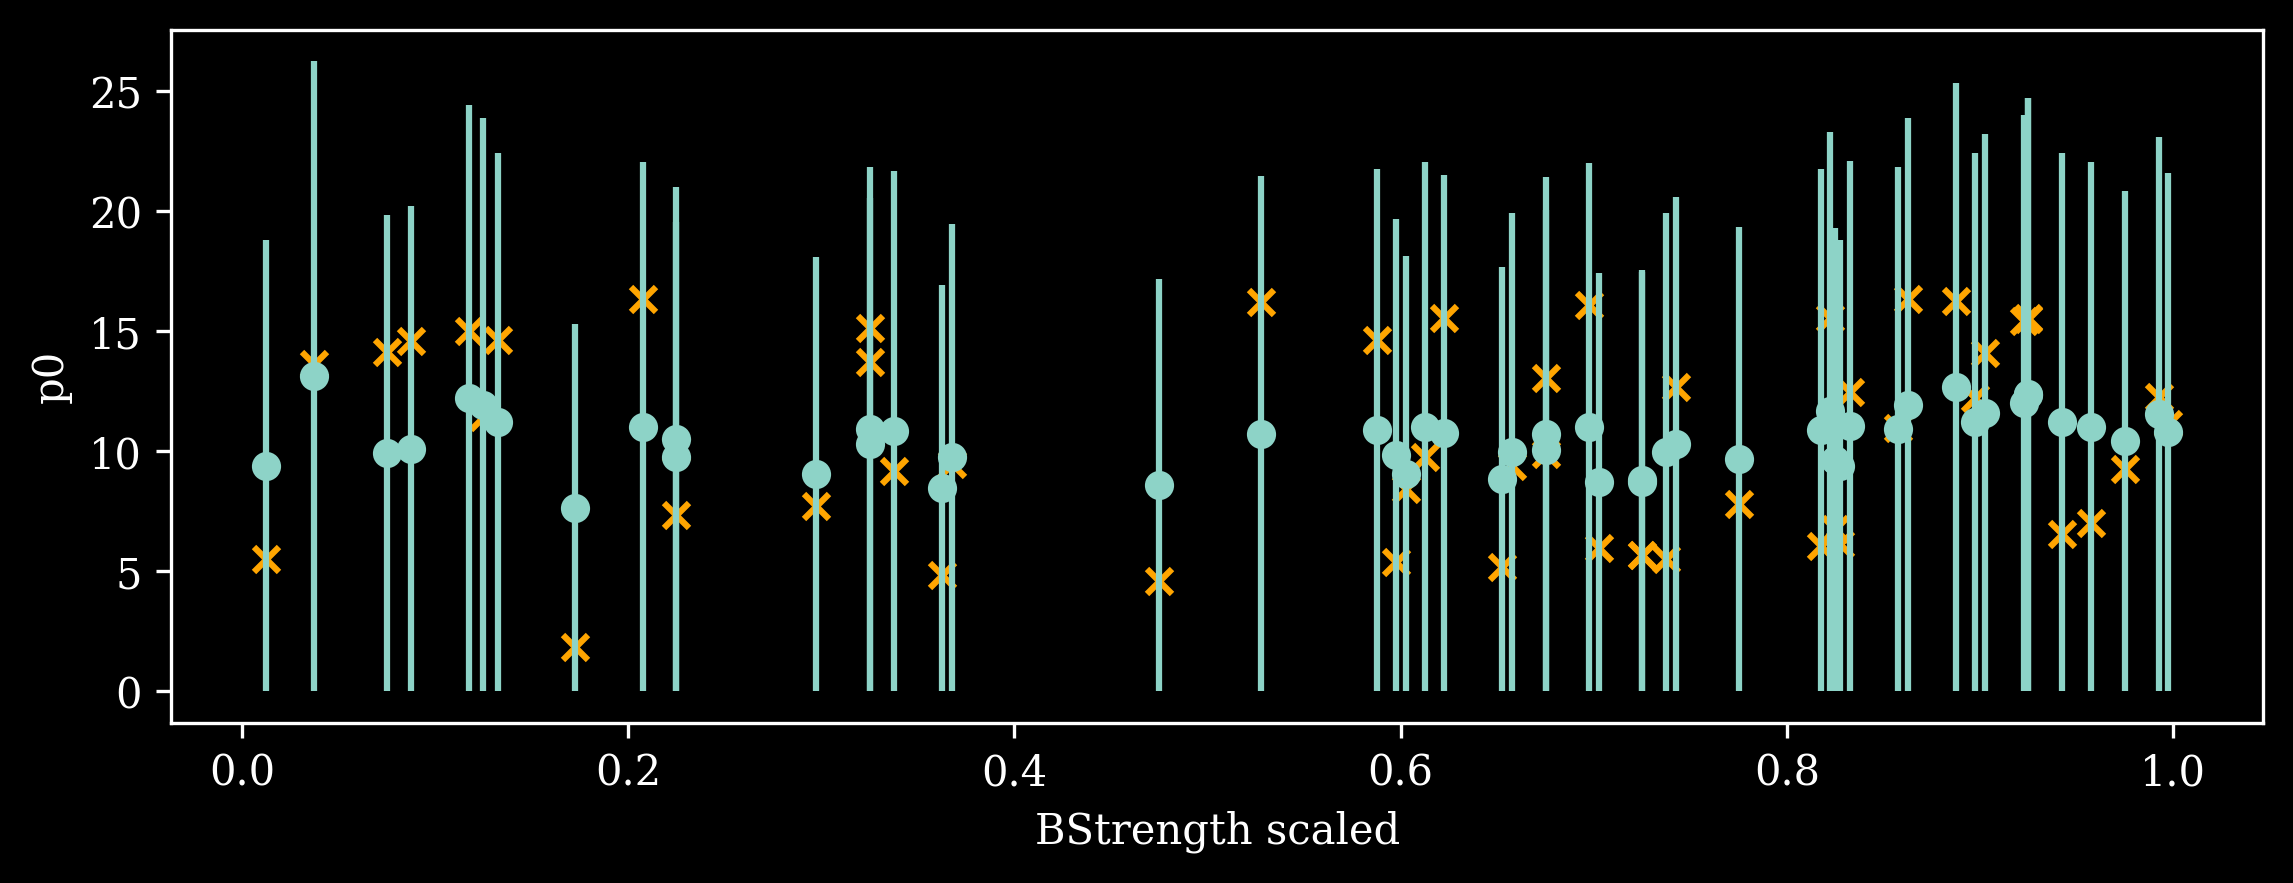

In [112]:
fig = plt.figure()
plt.errorbar(test_x_torch_final[:, 0], 
             mean_pred[:, 0], 
             yerr=err0,
             fmt="o"
            )
plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, 0],
           marker='x',
           c='orange')
plt.xlabel("BStrength scaled")
if family is None:
    plt.ylabel("p6")
else:
    plt.ylabel("p0")

In [ ]:
# fig = plt.figure()
# plt.errorbar(test_x_torch_final[:, 3], 
#              mean_pred[:, 0], 
#              yerr=err0,
#              fmt="o"
#             )
# plt.scatter(test_x_torch_final[:, 3],
#            test_y_torch_final[:, 0],
#            marker='x',
#            c='orange')
# plt.xlabel("BStrength scaled")
# if family is None:
#     plt.ylabel("p6")
# else:
#     plt.ylabel("p0")

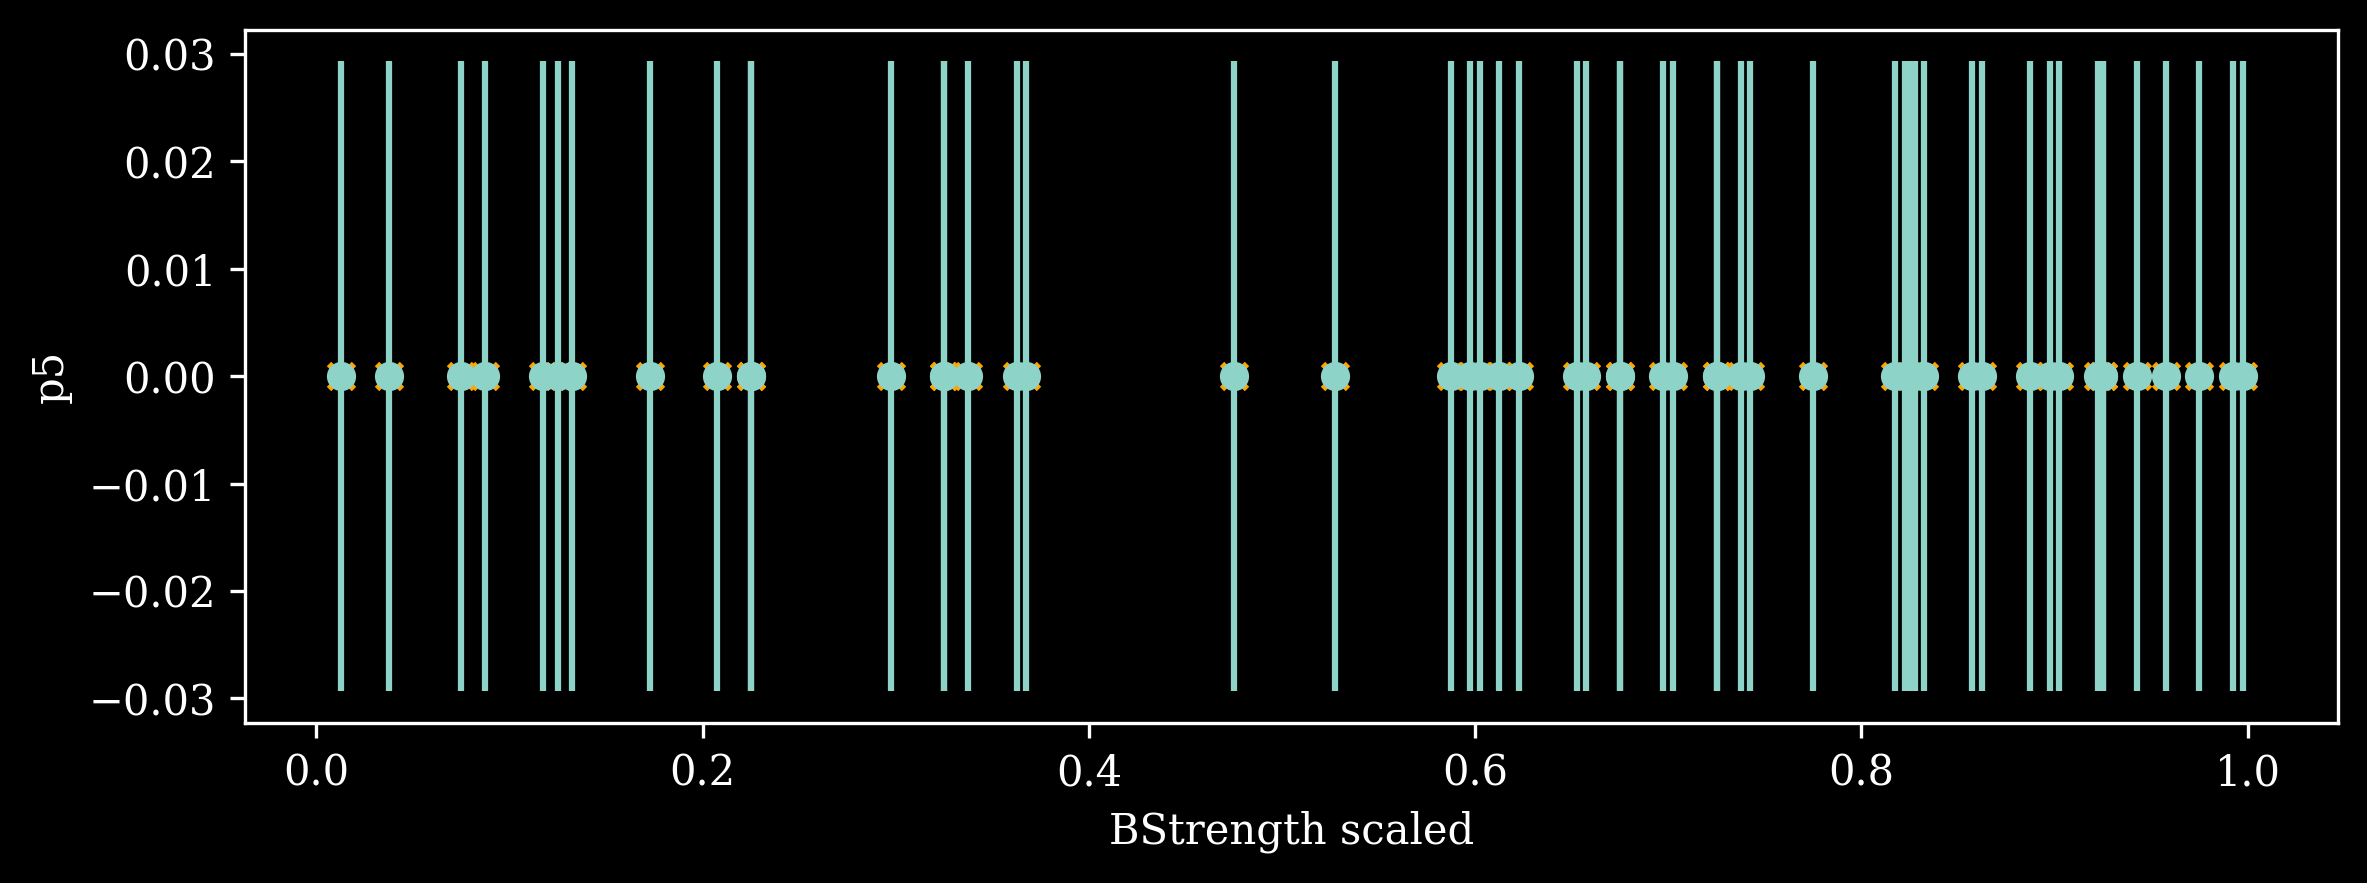

In [113]:
err_lin = np.vstack((np.abs(lower[:, -2].numpy()), upper[:, -2].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -2],
           marker='x',
           c='orange')

plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -2], 
             yerr=err_lin,
             fmt="o"
            )

plt.xlabel("BStrength scaled")
if family is None:
    plt.ylabel("p1")
else:
    plt.ylabel("p5")

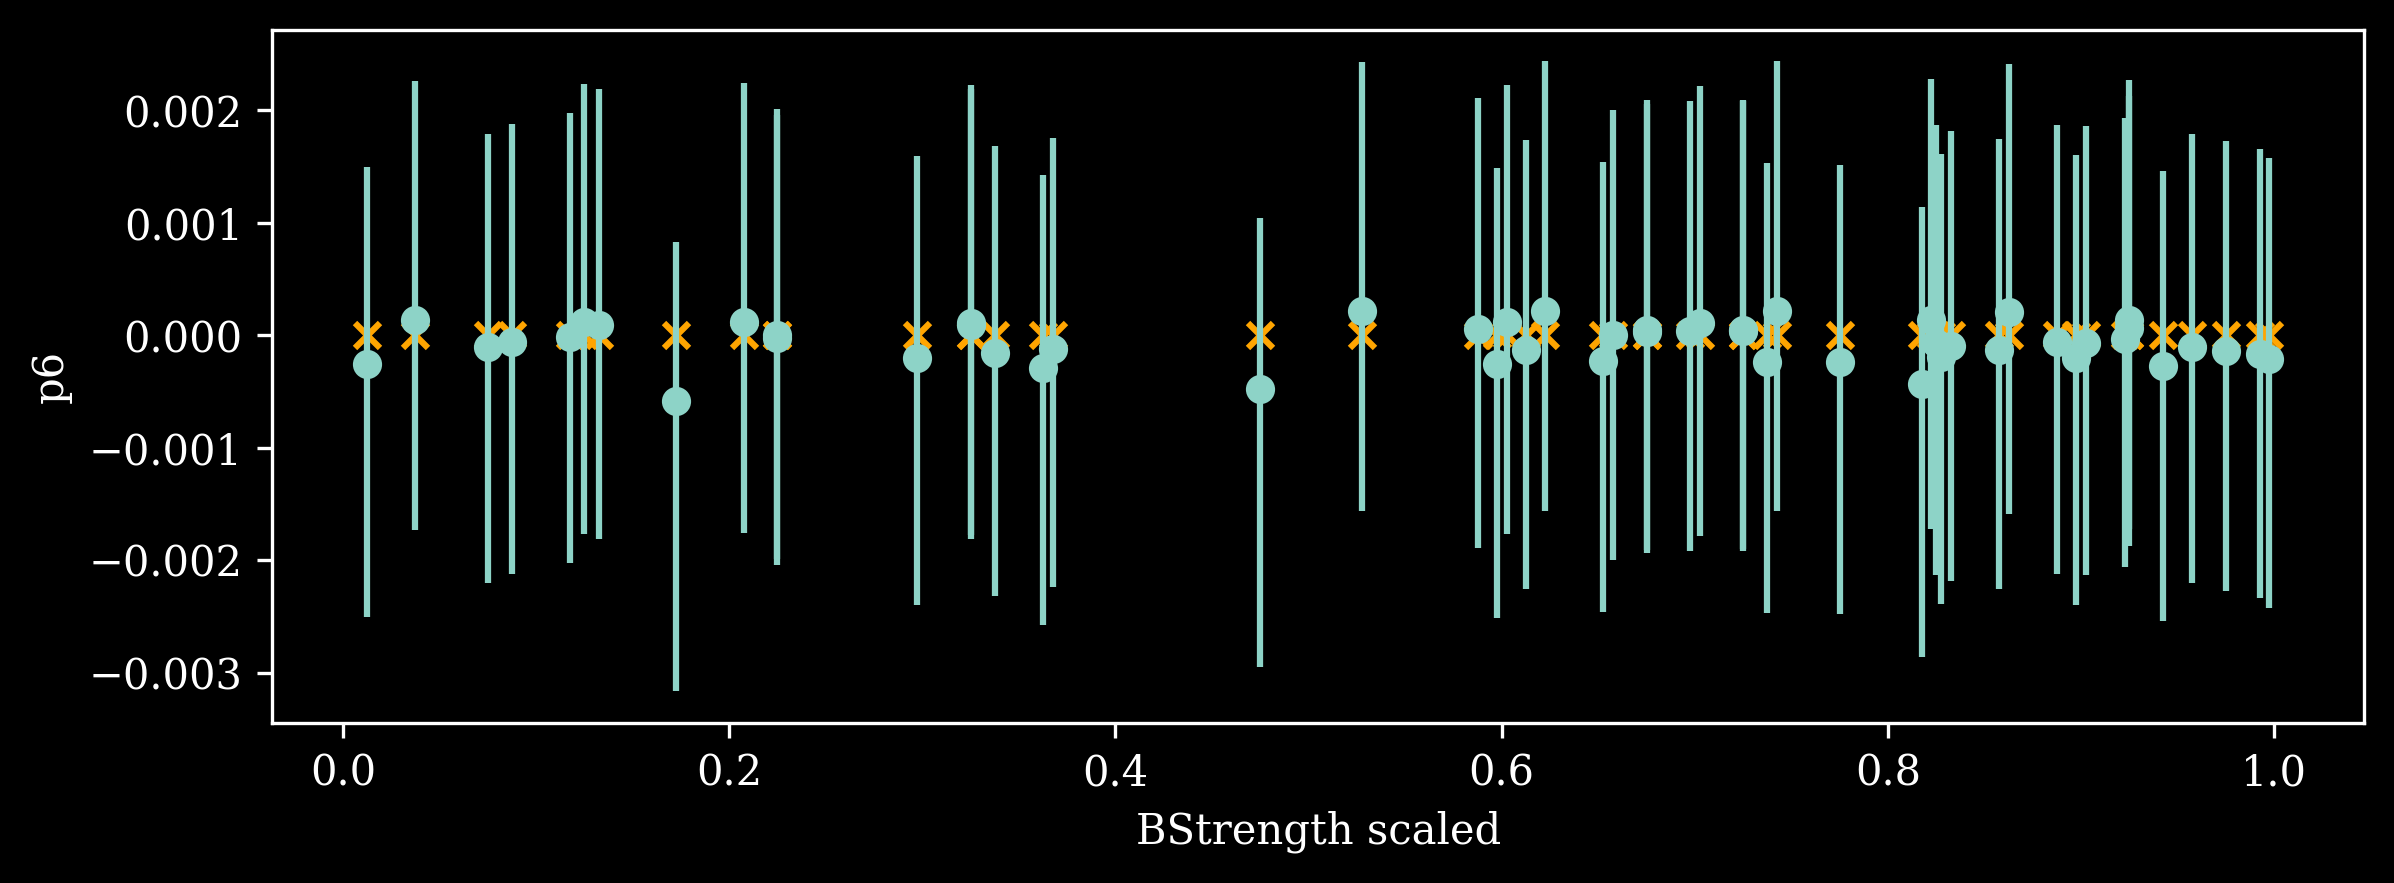

In [114]:
err_constant = np.vstack((np.abs(lower[:, -1].numpy()), upper[:, -1].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -1],
           marker='x',
           c='orange')
plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -1], 
             yerr=err_constant,
             fmt="o"
            )
plt.xlabel("BStrength scaled")

if family is None:
    plt.ylabel("p0")
else:
    plt.ylabel("p6")

_Results on test data with uncertainty_ first for $c_1$ (this would include only confidence from GP and not possible polynomial fitting error which could be a drawback), then the full series.

In [ ]:
c1_params_test.shape

Predict $c_1$ by sampling from the posterior predictive distribution of $p$

In [115]:
post_pred = torch.distributions.Normal(observed_pred.mean, observed_pred.stddev)

In [116]:
post_pred.sample().shape

torch.Size([53, 7])

Draw 1000 samples, store them in a tensor, fit $c_1$ by 6 degree polynomial and get results.

In [117]:
n_post_samples = 1000

In [118]:
p_test_samples = np.zeros((test_x_torch_final.shape[0], fit_deg + 1, n_post_samples))
for i in range(n_post_samples):
    p_test_samples[:, :, i] = post_pred.sample().numpy()

print("Generated {} samples from posterior".format(n_post_samples))

Generated 1000 samples from posterior


In [119]:
p_test_samples[0, :, 0].shape

(7,)

In [120]:
c1_test = np.zeros((test_x_torch_final.shape[0], 160, n_post_samples))

for i in range(n_post_samples):
    for j in range(test_x_torch_final.shape[0]):
        #         c1_test[j, :, i] = getPredPolyFit(p_test_samples[j, :, i], theta_grid)
        c1_test[j, :, i] = valPolyCoeffs(theta_grid, p_test_samples[j, :, i], family=family)

print("Generated {} test velocities with {} replicates".format(test_x_torch_final.shape[0], n_post_samples))

Generated 53 test velocities with 1000 replicates


In [121]:
mean_c1 = np.mean(c1_test, axis=2)
std_c1 = np.std(c1_test, axis=2)

mean_c1.shape, std_c1.shape

((53, 160), (53, 160))

Plot a few test velocities versus the actual and examine outputs

In [122]:
c1_params_test.shape

(53, 160)

In [128]:
mean_c1[sd_test_id, :].min()

-1895900952.442735

In [129]:
mean_c1[sd_test_id, :].max()

11.106108335480268

Text(0.5, 1.0, 'Sim 79')

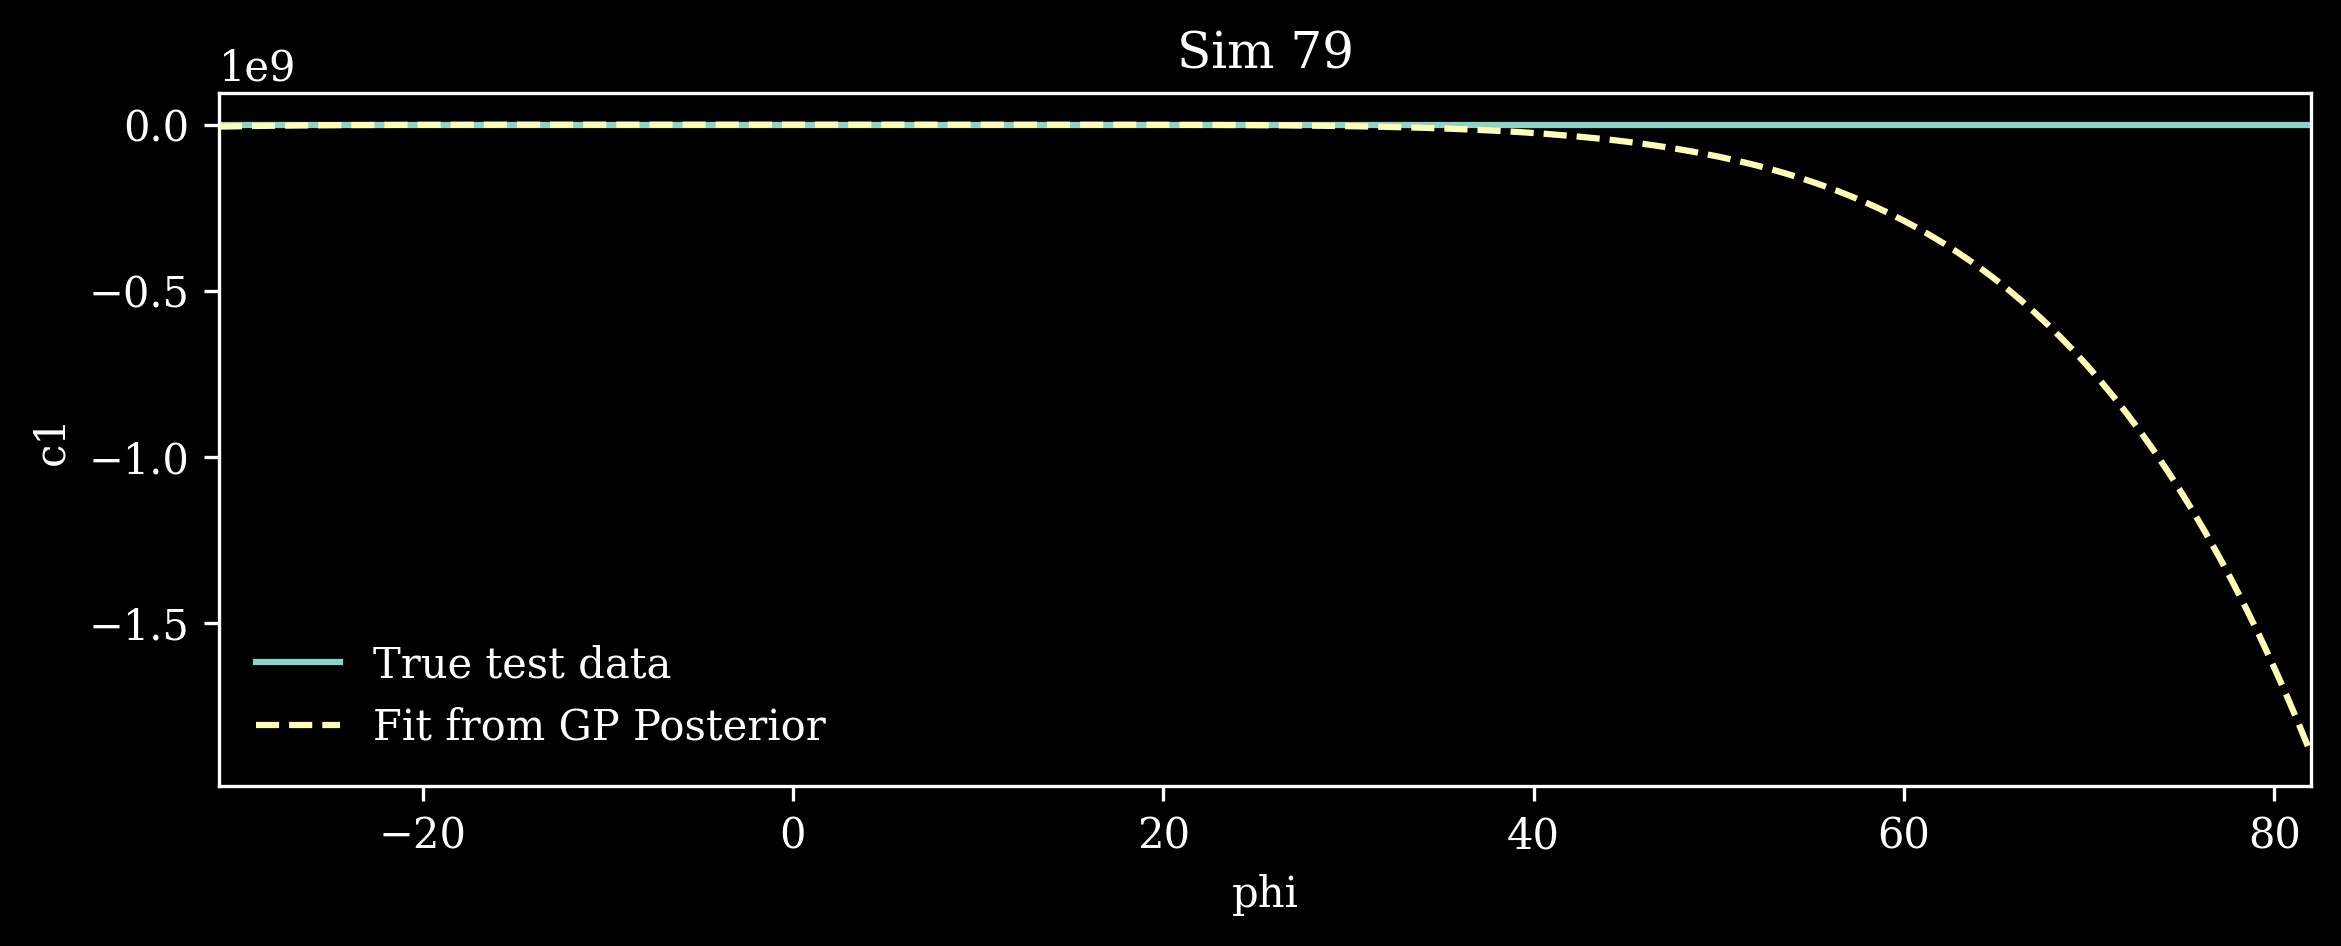

In [126]:
# for i in range(len(sd_train)):
sd_test_id = 6

plt.plot(theta_grid, c1_params_test[sd_test_id, :], label="True test data")
plt.plot(theta_grid, mean_c1[sd_test_id, :], linestyle="--", label="Fit from GP Posterior")
plt.xlabel("phi")
plt.ylabel("c1")
plt.xlim((-31, 82))
plt.legend()
plt.title("Sim {}".format(sd_test[sd_test_id]))
# plt.ylim((0, 20))
# plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
# plt.close()

(-10000000.0, 20.0)

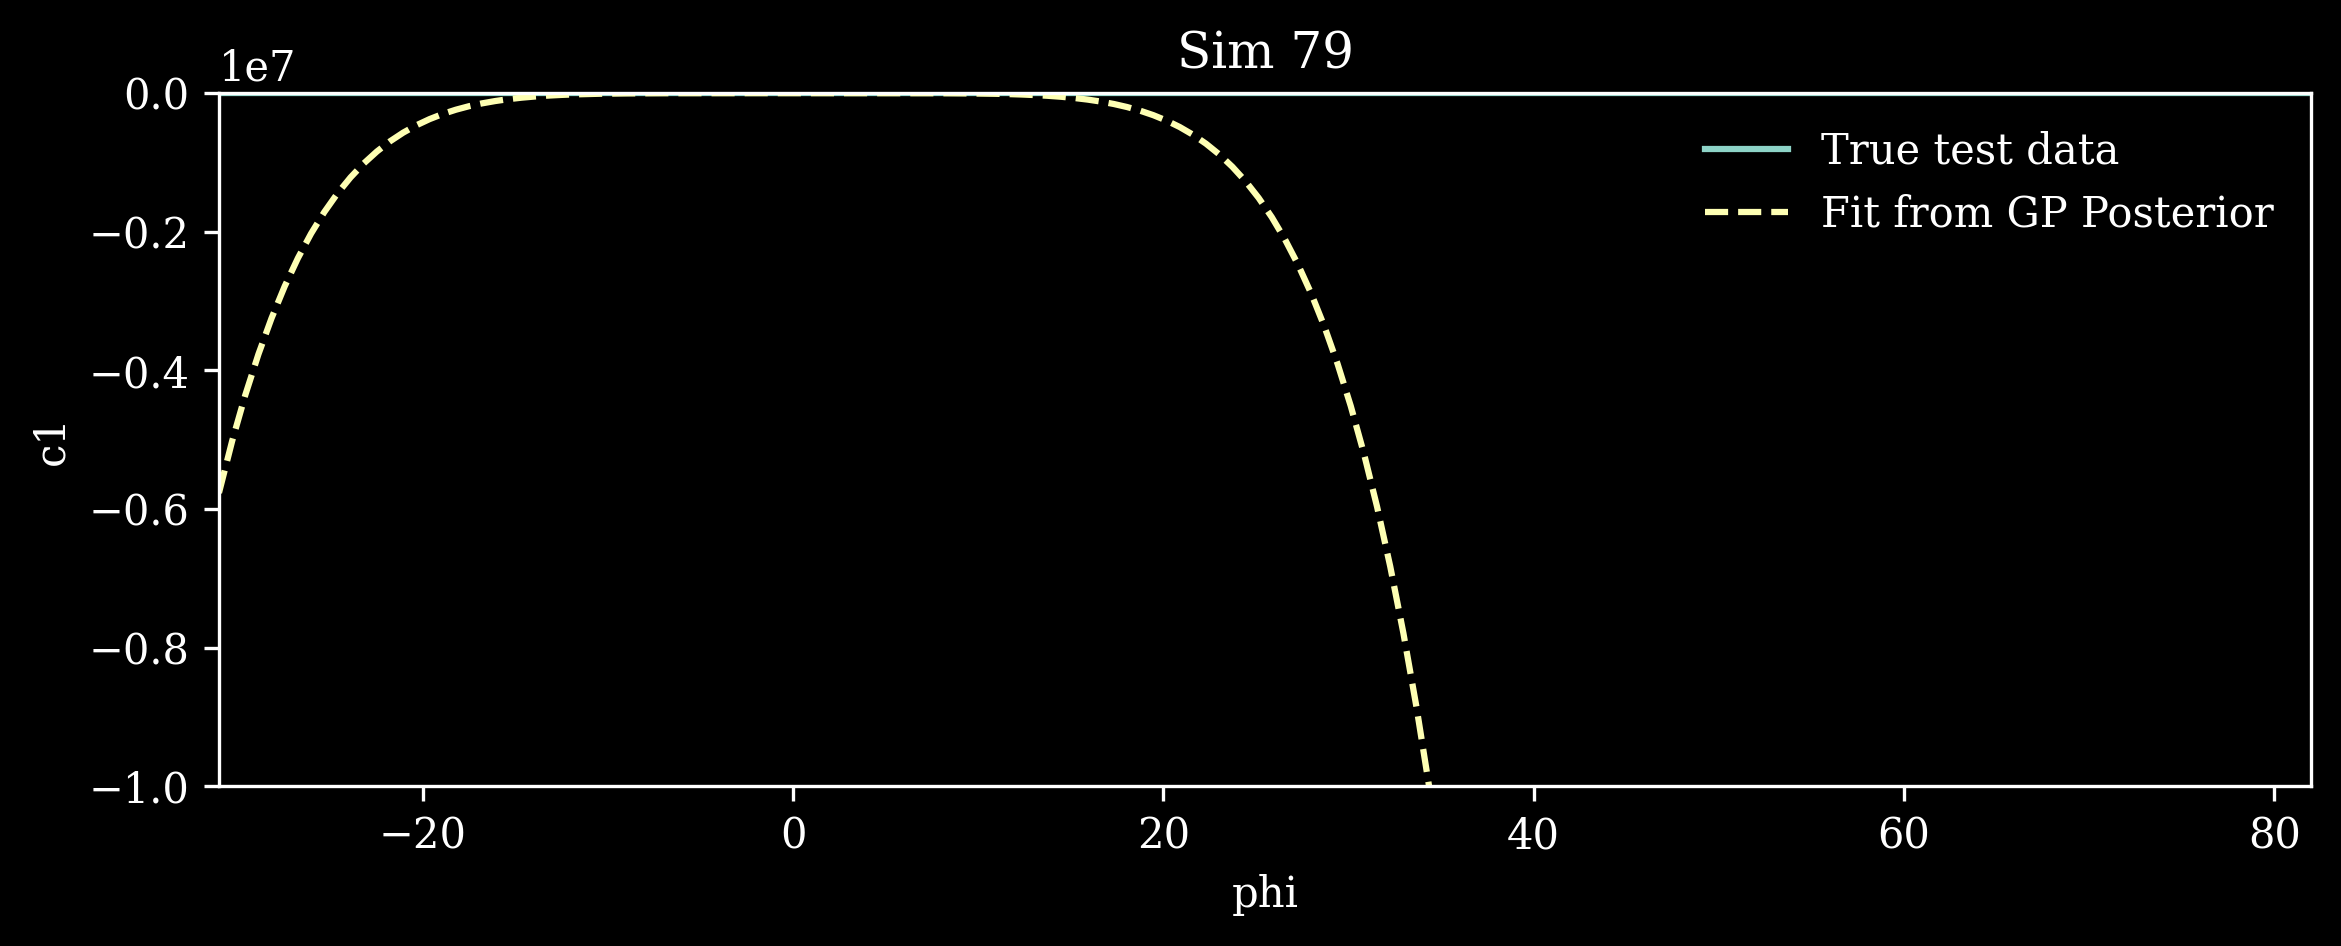

In [133]:
# for i in range(len(sd_train)):
sd_test_id = 6

plt.plot(theta_grid, c1_params_test[sd_test_id, :], label="True test data")
plt.plot(theta_grid, mean_c1[sd_test_id, :], linestyle="--", label="Fit from GP Posterior")
plt.xlabel("phi")
plt.ylabel("c1")
plt.xlim((-31, 82))
plt.legend()
plt.title("Sim {}".format(sd_test[sd_test_id]))
plt.ylim((-10000000, 20))
# plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
# plt.close()

#### Alternate: Fit GP to c1 directly.

This means position angle is also an independent parameter (but we can map it by a few points thanks to the polynomial fit)

In [ ]:
theta_interp = np.linspace(-31, 82, 40)
theta_interp

In [ ]:
polynomial_coeffs_test.shape

In [ ]:
# # for i in range(len(sd_train)):
# for i in range(len(sd_test)):
#     #     plt.plot(np.linspace(-31, 82, 160), c1_params_train[i, :], label="true")
#     plt.plot(np.linspace(-31, 82, 160), c1_params_test[i, :], label="true")
#     #     plt.plot(theta_interp, getPredPolyFit(polynomial_coeffs[:, i], theta_interp), linestyle="--", label="fit")
#     plt.plot(theta_interp, getPredPolyFit(polynomial_coeffs_test[:, i], theta_interp), linestyle="--", label="fit")
#     plt.xlabel("phi")
#     plt.ylabel("c1")
#     plt.xlim((-31, 82))
#     plt.legend()
#     #     plt.title("Sim {}".format(sd_train[i]))
#     plt.title("Sim {}".format(sd_test[i]))
#     #     plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
#     plt.savefig(os.path.join("c1_polynomial_fit_test", "sim_{:03d}.png".format(sd_test[i])))
#     plt.close()

In [ ]:
c1_params_train.shape, c1_params_test.shape

Try Approximate GP first with suitable DataLoader?

In [ ]:
c1_params_fit_train = np.zeros((len(sd_train), len(theta_interp)))
c1_params_fit_test = np.zeros((len(sd_test), len(theta_interp)))

for i in range(len(sd_train)):
    c1_params_fit_train[i, :] = getPredPolyFit(polynomial_coeffs[:, i], theta_interp)

for i in range(len(sd_test)):
    c1_params_fit_test[i, :] = getPredPolyFit(polynomial_coeffs_test[:, i], theta_interp)

In [ ]:
np.expand_dims(c1_params_fit_train.flatten(), 1).shape

In [ ]:
theta_interp_scaled = (theta_interp - (theta_interp[0])) / (theta_interp[-1] - theta_interp[0])
train_x_repeat = np.repeat(train_x_raw, len(theta_interp), axis=0)
test_x_repeat = np.repeat(test_x_raw, len(theta_interp), axis=0)


theta_repeat_train = np.tile(theta_interp_scaled, len(train_sd_idx))
theta_repeat_test = np.tile(theta_interp_scaled, len(test_sd_idx))


train_x_gp = np.c_[theta_repeat_train, train_x_repeat]
train_x_gp_torch = torch.tensor(np.float32(train_x_gp)).to(device)


test_x_gp = np.c_[theta_repeat_test, test_x_repeat]
test_x_gp_torch = torch.tensor(np.float32(test_x_gp)).to(device)

scalerY = StandardScaler()



# train_y_gp_torch = torch.tensor(np.float32(c1_params_fit_train.flatten())).to(device)
scalerY.fit(np.expand_dims(c1_params_fit_train.flatten(), 1))
train_y_gp_torch = torch.tensor(np.float32(np.squeeze(scalerY.transform(np.expand_dims(c1_params_fit_train.flatten(), 1))))).to(device)

# test_y_gp_torch = torch.tensor(np.float32(c1_params_fit_test.flatten())).to(device)
test_y_gp_torch = torch.tensor(np.float32(np.squeeze(scalerY.transform(np.expand_dims(c1_params_fit_test.flatten(), 1))))).to(device)

train_x_gp_torch.shape, test_x_gp_torch.shape, train_y_gp_torch.shape, test_y_gp_torch.shape

In [ ]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points = n_inducing,
                                                                                       batch_shape = torch.Size([]))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
n_inducing = 200

In [ ]:
model = ApproximateGPModel(torch.rand(n_inducing, 10))
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x_gp_torch, train_y_gp_torch)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [ ]:
objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_gp_torch.numel())
optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

In [ ]:
training_iterations = 200

In [ ]:
for i in range(training_iterations):
    for x, y in train_loader:
        output = model(x)
        loss = -objective_function(output, y)
        loss.backward()
        
        optimizer.step()
        
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.zero_grad()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_gp_torch))
    mean_pred = observed_pred.mean
    var_pred = observed_pred.variance
    lower, upper = observed_pred.confidence_region()

In [ ]:
mean_pred.shape

In [ ]:
var_pred.shape

In [ ]:
var_pred

In [ ]:
lower.shape, upper.shape

In [ ]:
lower

In [ ]:
upper

In [ ]:
mean_pred_transform = scalerY.inverse_transform(np.expand_dims(mean_pred.cpu().numpy(), 1))

In [ ]:
lower_tf = scalerY.inverse_transform(np.expand_dims(lower.cpu().numpy(), 1))
upper_tf = scalerY.inverse_transform(np.expand_dims(upper.cpu().numpy(), 1))

In [ ]:
# sigma

In [ ]:
true_test_transform = scalerY.inverse_transform(np.expand_dims(test_y_gp_torch.cpu().numpy(), 1))

In [ ]:
true_test_transform.shape

In [ ]:
len(sd_test)

In [ ]:
for i in range(len(sd_test)):

    #     sd_to_plot=48
    #     plt.plot(theta_interp, true_test_transform[40*(sd_to_plot):40*(sd_to_plot + 1), 0], label="True test data")
    #     plt.plot(theta_interp, mean_pred_transform[40*(sd_to_plot):40*(sd_to_plot + 1), 0], 
    #              linestyle="--", label="Fit from GP Prediction")
    #     plt.fill_between(theta_interp, lower_tf[40*(sd_to_plot):40*(sd_to_plot + 1), 0], 
    #                      upper_tf[40*(sd_to_plot):40*(sd_to_plot + 1), 0], alpha=0.3, label="Confidence")


    plt.plot(theta_interp, true_test_transform[40*(i):40*(i + 1), 0], label="True test data")
    plt.plot(theta_interp, mean_pred_transform[40*(i):40*(i + 1), 0], 
             linestyle="--", label="Fit from GP Prediction")
    plt.fill_between(theta_interp, lower_tf[40*(i):40*(i + 1), 0], 
                     upper_tf[40*(i):40*(i + 1), 0], alpha=0.3, label="Confidence")
    
    plt.xlabel("phi")
    plt.ylabel("c1")
    plt.xlim((-31, 82))
    plt.legend()
    plt.title("Sim {}".format(sd_test[i]))
    plt.savefig(os.path.join("./approx_gp_fits", "sim_{:03d}.png".format(sd_test[i])))
    plt.close()
    #     plt.title("Sim {}".format(sd_test[sd_to_plot]))


**Exact GP?**

In [ ]:
train_y_gp_torch = torch.tensor(np.float32(c1_params_fit_train.flatten())).to(device)
test_y_gp_torch = torch.tensor(np.float32(c1_params_fit_test.flatten())).to(device)

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3)).to(device)
model = ExactGPModel(train_x_gp_torch, train_y_gp_torch, likelihood)

In [ ]:
likelihood

In [ ]:
training_iters = 200

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
for i in range(training_iters):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_gp_torch)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y_gp_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iters, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_gp_torch))
    mean_pred = observed_pred.mean
    var_pred = observed_pred.variance
    lower, upper = observed_pred.confidence_region()

mean_pred.shape
# mean_pred_transform = scalerY.inverse_transform(np.expand_dims(mean_pred.cpu().numpy(), 1))

# lower_tf = scalerY.inverse_transform(np.expand_dims(lower.cpu().numpy(), 1))
# upper_tf = scalerY.inverse_transform(np.expand_dims(upper.cpu().numpy(), 1))

# # sigma

# true_test_transform = scalerY.inverse_transform(np.expand_dims(test_y_gp_torch.cpu().numpy(), 1))
# true_test_transform.shape

In [ ]:
for i in range(len(sd_test)):
    plt.plot(theta_interp, test_y_gp_torch[40*(i):40*(i + 1)], label="True test data")
    plt.plot(theta_interp, mean_pred[40*(i):40*(i + 1)], 
             linestyle="--", label="Fit from GP Prediction")
    plt.fill_between(theta_interp, lower[40*(i):40*(i + 1)], 
                     upper[40*(i):40*(i + 1)], alpha=0.3, label="Confidence")

    plt.xlabel("phi")
    plt.ylabel("c1")
    plt.xlim((-31, 82))
    plt.legend()
    plt.title("Sim {} Exact".format(sd_test[i]))
    plt.savefig(os.path.join("./exact_gp_fits", "sim_{:03d}.png".format(sd_test[i])))
    plt.close()

What else can we try??

_Normal interpolation_??

UQ with conditional predictions?

_Transfer methods?_

**Plot histograms of CME Params from 2 Events (domain shift)?**

#### Try Linear Fit for Velocity Again

**Next Steps?**